# Introduction to Model Predictive Control

## Step Response Data

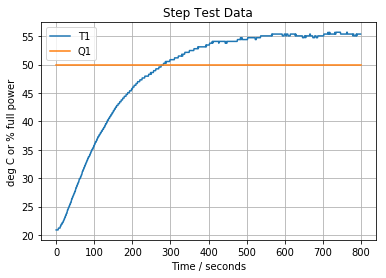

In [224]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('Step_Test_Data.csv')

# time, T1, Q1 data
t = np.array(data['Time'][1:])
T1 = np.array(data['T1'][1:])
Q1 = np.array(data['Q1'][1:])

plt.plot(t,T1,t,Q1)
plt.legend(['T1','Q1'])
plt.title('Step Test Data')
plt.xlabel('Time / seconds')
plt.ylabel('deg C or % full power')
plt.grid()

## Unit Step Response

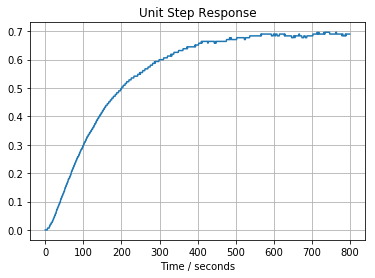

In [225]:
s = (T1 - T1[0])/max(Q1)
plt.plot(t, s)
plt.title('Unit Step Response')
plt.xlabel('Time / seconds')
plt.grid()

## Step Response Matrix

In [226]:
def step_response_matrix(s, ncols=1):
    S = np.zeros([len(s),ncols])
    for n in range(ncols):
        S[n:,n] = s[n:]
    return S

# alternative
from scipy.linalg import toeplitz
S = toeplitz(s,[0,0,0,0,0])

S[0:30,:]

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.0064,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.0064,  0.0064,  0.    ,  0.    ,  0.    ],
       [ 0.0064,  0.0064,  0.0064,  0.    ,  0.    ],
       [ 0.0064,  0.0064,  0.0064,  0.0064,  0.    ],
       [ 0.0064,  0.0064,  0.0064,  0.0064,  0.0064],
       [ 0.0128,  0.0064,  0.0064,  0.0064,  0.0064],
       [ 0.0128,  0.0128,  0.0064,  0.0064,  0.0064],
       [ 0.0194,  0.0128,  0.0128,  0.0064,  0.0064],
       [ 0.0194,  0.0194,  0.0128,  0.0128,  0.0064],
       [ 0.0194,  0.0194,  0.0194,  0.0128,  0.0128],
       [ 0.0258,  0.0194,  0.0194,  0.0194,  0.0128],
       [ 0.0258,  0.0258,  0.0194,  0.0194,  0.0194],
       [ 0.0258,  0.0258,  0

## Computing Response to Changes in Manipulated Variable

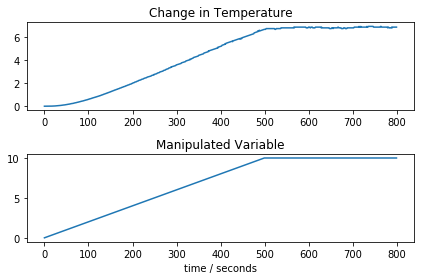

In [227]:
# changes in manipulated variable
du = np.zeros(len(t))
du[0:500] = 0.02

# predict values of output
S = step_response_matrix(s, len(du))
y_pred = S.dot(du)

# plot
plt.subplot(2,1,1)
plt.plot(t, y_pred)
plt.title('Change in Temperature')

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du))
plt.title('Manipulated Variable')
plt.xlabel('time / seconds')

plt.tight_layout()

## Computing Inputs Needed to Produce a Desired Output

### Ramp Setpoint

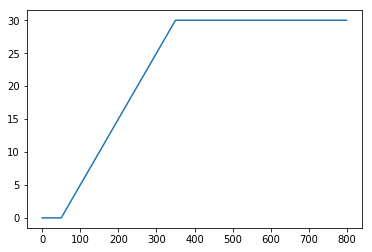

In [5]:
y_setpoint = [0 if (t<50) else 0.1*(t-50) if (t < 350) else 30 for t in t]
plt.plot(t, y_setpoint)

### Confirm the Step Reponse Matrix equations can be solved

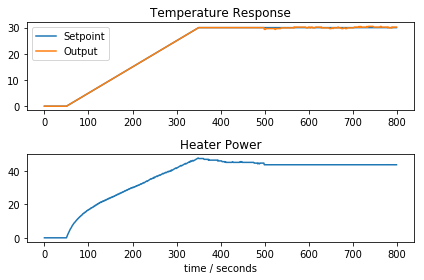

In [7]:
from numpy.linalg import lstsq
import numpy as np

S = step_response_matrix(s, 500)

du = np.linalg.lstsq(S, y_setpoint)[0]

plt.subplot(2,1,1)
plt.plot(t, y_setpoint, t, S.dot(du))
plt.title('Temperature Response')
plt.legend(['Setpoint','Output'])

du_full = np.append(du,np.zeros(len(t)-len(du)))

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du_full))
plt.title('Heater Power')
plt.xlabel('time / seconds')

plt.tight_layout()

### Let's try a different output response

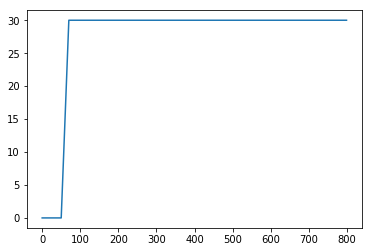

In [8]:
n = 20

y_setpoint = [0 if (t<50) else (30/n)*(t-50) if (t < 50 + n) else 30 for t in t]
plt.plot(t, y_setpoint)

### Confirm the Step Reponse Matrix equations can be solved

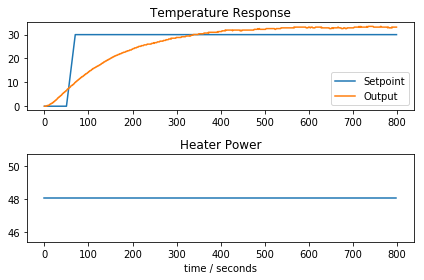

In [10]:
from numpy.linalg import lstsq
import numpy as np

S = step_response_matrix(s, 1)

du = np.linalg.lstsq(S, y_setpoint, rcond=0.001)[0]

plt.subplot(2,1,1)
plt.plot(t, y_setpoint, t, S.dot(du))
plt.title('Temperature Response')
plt.legend(['Setpoint','Output'])

du_pad = np.append(du,np.zeros(len(t)-len(du)))

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du_pad))
plt.title('Heater Power')
plt.xlabel('time / seconds')

plt.tight_layout()

## Alternative Solution Methods


\begin{align}
\delta & = A x - b
\end{align}

Solve by minimizing $\|\delta \|_2$

\begin{align}
\|\delta\|_2^2 & = (Ax - b)^T(Ax - b) \\
& = x^TA^TAx - b^TAx - x^TA^Tb + b^Tb \\
& = x^TA^TAx - 2 b^TA^Tx + b^Tb
\end{align}

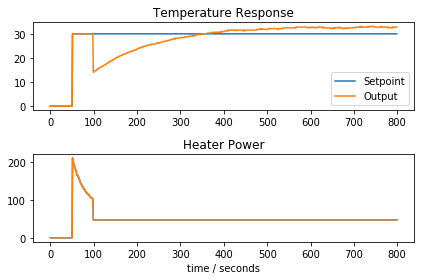

In [156]:
from numpy.linalg import lstsq
from scipy.optimize import minimize
import numpy as np

n = 1

t = np.array(data['Time'][1:])
N = len(t)

y_setpoint = [0 if (t<50) else (30/n)*(t-50) if (t < 50 + n) else 30 for t in t]
u_setpoint = [0 for t in t]
plt.plot(t, y_setpoint)

K = 100

S = step_response_matrix(s, K)
I = np.eye(K)
U = step_response_matrix(np.ones(len(s)), K)

SU = np.concatenate((S, 0*I, 0*U))
SP = np.concatenate((y_setpoint, [0 for _ in range(K)], [0 for t in t]))

def loss(du):
    d = SU.dot(du) - SP
    return d.dot(d)

#du, residuals, rank, _ = np.linalg.lstsq(SU, SP, rcond=.005)
#print(rank)

constraints = [{'type': 'ineq', 'fun': lambda du: 100-(U[k].dot(du))} for k in range(K)]

ddu = minimize(loss, np.zeros(K), method='SLSQP', constraints=constraints)
du = ddu.x

plt.subplot(2,1,1)
plt.plot(t, y_setpoint, t, S.dot(du))
plt.title('Temperature Response')
plt.legend(['Setpoint','Output'])

du_pad = np.append(du,np.zeros(len(t)-len(du)))

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du_pad))
plt.plot(t, U.dot(du))
plt.title('Heater Power')
plt.xlabel('time / seconds')

plt.tight_layout()

34083.482252496266

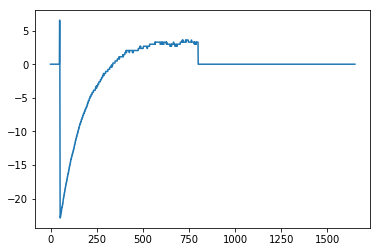

In [152]:
plt.plot(SU.dot(ddu.x) - SP)
loss(ddu.x)

## Alternative Solution Methods using LP

Suppose we are given an overdetermined set of equations

\begin{align}
Ax & =  b
\end{align}

where $A \in R^{N \times M}$ and $n > m$. Generally speaking, there may not be a solution to these equations, so the best we can do is to minimize $\|\delta\|$ where

\begin{align}
\delta & = Ax -  b
\end{align}

In particular, we'll consider the case

\begin{align}
\min_{x,\delta}\|\delta\|_1  & = \min_{x,\delta} \sum_{n = 1}^N |\delta_n| \\
& = \min_{x, \delta^p \geq 0, \delta^n \geq 0} \sum_{n = 1}^N \delta^+_n - \delta^-_n \\
\end{align}

where

\begin{align}
\delta^+ - \delta^- & = Ax -  b
\end{align}

In [255]:
from pyomo.environ import *
import numpy as np

A = np.array([[1, 3], [1, 4], [3, 2]])
b = np.array([ -2, -4, 1])

def solveglpk(S, y):
    N,M = S.shape
    model = ConcreteModel()
    model.x = Var(range(M), domain=Reals)
    model.d = Var(range(N), domain=NonNegativeReals)
    model.e = Var(range(N), domain=NonNegativeReals)
    norm = sum(model.d[n] for n in range(N)) + sum(model.e[n] for n in range(N))
    model.objective = Objective(expr = norm, sense=minimize)
    model.cons = ConstraintList()
    for n in range(N):
        model.cons.add(model.d[n] - model.e[n] == sum(S[n,m]*model.x[m] for m in range(M)) - y[n])
    SolverFactory('glpk').solve(model)
    return [model.x[m]() for m in range(M)]
    
print(solveglpk(A, b))

[1.2, -1.3]


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 555.818466186535
  Upper bound: 555.818466186535
  Number of objectives: 1
  Number of constraints: 2399
  Number of variables: 2001
  Number of nonzeros: 402180
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 1.567615032196045
# ----------------------------------------------------------
#   Solution Information
# ------

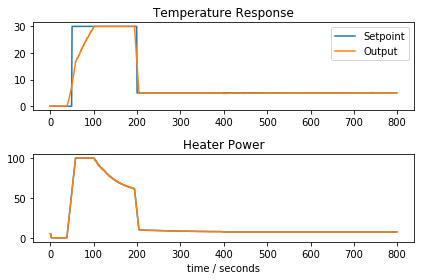

In [282]:
#t = np.array(data['Time'][1:])
N = len(t)

y = [0 if (t<50) else 30 if (t<200) else 5 for t in t]
plt.plot(t, y)

M = 400

S = step_response_matrix(s, M)
U = step_response_matrix(np.ones(len(s)), M)

model = ConcreteModel()
model.x = Var(range(M), domain=Reals)
model.d = Var(range(N), domain=NonNegativeReals)
model.e = Var(range(N), domain=NonNegativeReals)
norm = sum(model.d[n] for n in range(N)) + sum(model.e[n] for n in range(N))
model.objective = Objective(expr = norm, sense=minimize)
model.cons = ConstraintList()
for n in range(N):
    model.cons.add(model.d[n] - model.e[n] == sum(S[n,m]*model.x[m] for m in range(M)) - y[n])
for m in range(1,M):
    model.cons.add(0 <= sum(model.x[k] for k in range(m)) <= 100)
for m in range(M):
    model.cons.add(-5 <= model.x[m] <= 5)
SolverFactory('glpk').solve(model).write()
du = [model.x[m]() for m in range(M)]

plt.subplot(2,1,1)
plt.plot(t, y, t, S.dot(du))
plt.title('Temperature Response')
plt.legend(['Setpoint','Output'])

du_pad = np.append(du,np.zeros(len(t)-len(du)))

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du_pad))
plt.plot(t, U.dot(du))
plt.title('Heater Power')
plt.xlabel('time / seconds')

plt.tight_layout()

In [249]:
from numpy.linalg import lstsq
from scipy.optimize import minimize
import numpy as np


t = np.array(data['Time'][1:])
N = len(t)

y_setpoint = [0 if (t<50) else 30 for t in t]
u_setpoint = [0 for t in t]
plt.plot(t, y_setpoint)

K = 1

S = step_response_matrix(s, K)
U = step_response_matrix(np.ones(len(s)), K)


du = solvelp(S, y_setpoint)

plt.subplot(2,1,1)
plt.plot(t, y_setpoint, t, S.dot(du))
plt.title('Temperature Response')
plt.legend(['Setpoint','Output'])

du_pad = np.append(du,np.zeros(len(t)-len(du)))

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du_pad))
plt.plot(t, U.dot(du))
plt.title('Heater Power')
plt.xlabel('time / seconds')

plt.tight_layout()

TypeError: 'module' object is not subscriptable

In [206]:
du

nan

In [ ]:
K = 100

S = step_response_matrix(s, K)
I = np.eye(K)
U = step_response_matrix(np.ones(len(s)), K)

SU = np.concatenate((S, 0*I, 0*U))
SP = np.concatenate((y_setpoint, [0 for _ in range(K)], [0 for t in t]))

def loss(du):
    d = SU.dot(du) - SP
    return d.dot(d)

#du, residuals, rank, _ = np.linalg.lstsq(SU, SP, rcond=.005)
#print(rank)

constraints = [{'type': 'ineq', 'fun': lambda du: 100-(U[k].dot(du))} for k in range(K)]

ddu = minimize(loss, np.zeros(K), method='SLSQP', constraints=constraints)
du = ddu.x

plt.subplot(2,1,1)
plt.plot(t, y_setpoint, t, S.dot(du))
plt.title('Temperature Response')
plt.legend(['Setpoint','Output'])

du_pad = np.append(du,np.zeros(len(t)-len(du)))

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du_pad))
plt.plot(t, U.dot(du))
plt.title('Heater Power')
plt.xlabel('time / seconds')

plt.tight_layout()

# Let's make this a feedback loop

In [ ]:
from numpy.linalg import lstsq
import numpy as np

# predictive model
S = step_response_matrix(s, 500)
P, M = S.shape

# simulation length
K = 200

u_hist = np.zeros(0)
u = 0

# construct setpoint
n = 20
t = [t for t in range(0, P+K)]
y_setpoint = 22 + np.array([0 if (t<50) else (30/n)*(t-50) if (t < 50 + n) else 30 for t in t])

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t, y_setpoint)

plt.subplot(2,1,2)
plt.plot(0,0)

# initialize simulation
y_pred = 22 + np.zeros(P)

for k in range(K):
    
    y_diff = y_setpoint[k:k+P] - y_pred
    du = np.linalg.lstsq(S, y_diff, rcond=0.001)[0]
    y_pred = S.dot(du) + y_pred
    y_pred = np.append(y_pred[1:],y_pred[-1])
    
    plt.subplot(2,1,1)
    plt.plot(t[k:k+P], y_pred)
    
    plt.subplot(2,1,2)
    plt.plot(t[k:k+M], du)
    
    

/Users/jeff/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [ ]:
for k in range(50):

    du = np.linalg.lstsq(S, y_setpoint, rcond=0.001)[0]

plt.subplot(2,1,1)
plt.plot(t, y_setpoint, t, S.dot(du))
plt.title('Temperature Response')
plt.legend(['Setpoint','Output'])

du_full = np.append(du,np.zeros(len(t)-len(du)))

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du_full))
plt.title('Heater Power')
plt.xlabel('time / seconds')

plt.tight_layout()

## Linear Programming with Pyomo

In [ ]:
from pyomo.environ import *
import numpy as np

# data
A = np.array([
    [1.0, 0.1], 
    [2.0, 2.0],
    [3.0, -1]])

y_fit = [2, 3, 2]

A = step_response_matrix(S, 100)
n = 200
y_fit = [0 if (t<50) else (30/n)*(t-50) if (t < 50 + n) else 30 for t in t]



M, N = A.shape
assert(M == len(y_fit))

# Pyomo model
model = ConcreteModel()

model.x = Var(range(N), domain=Reals)
model.d = Var(range(M), domain=NonNegativeReals)
model.e = Var(range(M), domain=NonNegativeReals)

model.cons = ConstraintList()
for m in range(M):
    model.cons.add(model.d[m] >= y_fit[m] - sum(model.x[n]*A[m,n] for n in range(N)))
    model.cons.add(model.e[m] >= sum(model.x[n]*A[m,n] for n in range(N)) - y_fit[m])

u = 0
for n in range(N):
    u = u + model.x[n]
    model.cons.add(u <= 100)
    model.cons.add(u >= 0)

model.Objective(expr = sum(model.d[m] + model.e[m] for m in range(M)), sense=minimize)
SolverFactory('ipopt').solve(model).write()

# visualization

%matplotlib inline
import matplotlib.pyplot as plt

du = np.array([model.x[n]() for n in range(N)])

y_pre = y_fit.copy()
for m in range(M):
    y_pre[m] = sum(A[m,n]*model.x[n]() for n in range(N))

plt.subplot(2,1,1)
plt.plot(range(M), y_fit)
plt.plot(range(M), [y_pre[m] for m in range(M)])

plt.subplot(2,1,2)
plt.plot(range(N), np.cumsum(du))

In [ ]:
from pyomo.environ import *
import numpy as np

H = len(t)
M = 500

model = ConcreteModel()
model.du = Var(range(M), domain=Reals)


model.constraints = ConstraintList()
for k in range(0,len(model.du)):
    model.constraints.add(model.du[k] <= 100)
    model.constraints.add(model.du[k] >= -100)

v = [( - Smatrix[k].dot(model.du))**2 for k in range(3)]
    
model.OBJ = Objective(expr = sum(v), sense=minimize)

SolverFactory('ipopt').solve(model).write()

du = [model.du[k]() for k in range(0, M)]

In [ ]:
v = [(y_setpoint[k] - Smatrix[k].dot(model.du))**2 for k in range(H)]
print(v)
    
model.OBJ = Objective(expr = sum(v), sense=minimize)

SolverFactory('ipopt').solve(model).write()

du = [model.du[k]() for k in range(0, M)]


plt.subplot(2,1,1)
plt.plot(t, y_setpoint, t, Smatrix.dot(du))
plt.title('Temperature Response')
plt.legend(['Setpoint','Output'])

du_full = np.append(du,np.zeros(H-M))

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du_full))
plt.title('Heater Power')
plt.xlabel('time / seconds')

plt.tight_layout()